In [180]:
import numpy as np
import pandas as pd
import os
import dtreeviz

import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

dsHotelTest = pd.read_csv('hotels_test.csv')
dsHotelTestCopy = dsHotelTest.copy()
dsCHP1 = pd.read_csv('dsHotelCHP1 (1).csv')
dsCHP1Copy = dsCHP1.copy()
dsHotelTrain = pd.read_csv('hotels_train.csv')


# Feature Engeneering (Transformaciones)

Basicamente lo que voy a hacer es realizar las mismas transformaciones que hice en train en test. Ademas voy a agregar nuevas transformaciones tanto en train como en test

In [181]:
dsCHP1Copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60414 entries, 0 to 60413
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60414 non-null  object 
 1   lead_time                       60414 non-null  int64  
 2   arrival_date_year               60414 non-null  int64  
 3   arrival_date_month              60414 non-null  int64  
 4   arrival_date_day_of_month       60414 non-null  int64  
 5   stays_in_weekend_nights         60414 non-null  int64  
 6   stays_in_week_nights            60414 non-null  int64  
 7   adults                          60414 non-null  int64  
 8   children                        60414 non-null  int64  
 9   babies                          60414 non-null  int64  
 10  meal                            60414 non-null  object 
 11  country                         60414 non-null  object 
 12  market_segment                  

In [182]:
dsHotelTestCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

## Transformacion de atributos categoricos
Aquellos atributos categoricos que tienen demasiados valores unicos como 'country', vamos a reemplazarlo con un nuevo campo que simplemente tenga los 10 valores mas frecuentes (incluyendo el valor de Otros).
Aplicamos One Hot Encoding a dichas variables

In [332]:
meses_a_numeros = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
dsHotelTestCopy['arrival_date_month'] = dsHotelTestCopy['arrival_date_month'].map(meses_a_numeros)

In [184]:
def verificar_enteros_disfrazados(datos):
    enteros_disfrazados = True
    for valor in datos:
        valor_str = str(valor)
        partes = valor_str.split('.')
        if len(partes) > 1 and partes[1] != '0':
            enteros_disfrazados = False
            break
    if enteros_disfrazados:
        print("Los valores son enteros disfrazados como flotantes.")
    else:
        print("Los valores son flotantes genuinos.")

In [333]:
variables_flotantes = ["children", "company"]

for categoria in variables_flotantes:
  dsHotelTestCopy[categoria].fillna(-10000, inplace=True)
  dsHotelTestCopy[categoria] = dsHotelTestCopy[categoria].astype('Int64')
  dsHotelTestCopy[categoria].replace(-10000, np.nan, inplace=True)
  verificar_enteros_disfrazados(dsHotelTestCopy[categoria])
dsHotelTestCopy.info()

Los valores son enteros disfrazados como flotantes.
Los valores son enteros disfrazados como flotantes.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              0 non-null      float64
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  Int64  
 10  babies                          26535 non-null  in

### Para la variable 'country'

In [334]:
dsCHP1Copy['country'] = dsCHP1Copy['country'].where(        #Lo hacemos para el dataframe preprocesado en train
dsCHP1Copy['country'].isin(dsCHP1Copy['country'].value_counts().nlargest(10).index), 'Others')

dsHotelTestCopy['country'] =dsHotelTestCopy['country'].where(        #Lo hacemos para test
dsHotelTestCopy['country'].isin(dsHotelTestCopy['country'].value_counts().nlargest(10).index), 'Others')

### Para la variable 'agent'

Realizo el mismo tratamiento de la variable 'agent' en el test

In [187]:
dsHotelTestCopy['agent'].fillna(-1, inplace=True)
dsHotelTestCopy['agent'].isnull().sum()

0

Dado que 'agent' tiene muchos valores tomo el top 10 de valores

In [188]:
dsCHP1Copy['agent'] = dsCHP1Copy['agent'].where(                #Lo hacemos para el dataframe preprocesado en train
dsCHP1Copy['agent'].isin(dsCHP1Copy['agent'].value_counts().nlargest(10).index), 'Others')

dsHotelTestCopy['agent'] =dsHotelTestCopy['agent'].where(        #Lo hacemos para test
dsHotelTestCopy['agent'].isin(dsHotelTestCopy['agent'].value_counts().nlargest(10).index), 'Others')

In [189]:
dsCHP1Copy['agent'].value_counts()

agent
Others    17131
9         16839
-1         7282
240        7214
1          4329
14         1673
6          1605
7          1550
250        1299
241         761
3           731
Name: count, dtype: int64

Creo un diccionario para la variable, asignando una letra a cada valor unico del top 10

In [190]:
valores_unicos = dsCHP1Copy['agent'].unique()
diccionario = {}
letra = 'A' 
for valor in valores_unicos:
    diccionario[valor] = letra
    letra = chr(ord(letra) + 1)
dsCHP1Copy['agent'] = dsCHP1Copy['agent'].map(diccionario)
print(diccionario)

{9: 'A', -1: 'B', 'Others': 'C', 240: 'D', 250: 'E', 1: 'F', 3: 'G', 14: 'H', 6: 'I', 7: 'J', 241: 'K'}


In [191]:
dsHotelTestCopy['agent'].value_counts()

agent
Others    7495
9.0       7324
-1.0      3363
240.0     2989
1.0       1983
6.0        717
14.0       700
7.0        696
250.0      573
3.0        353
8.0        342
Name: count, dtype: int64

In [192]:
dsHotelTestCopy['agent'] = dsHotelTestCopy['agent'].map(diccionario)
dsHotelTestCopy['agent'].value_counts()

agent
C    7495
A    7324
B    3363
D    2989
F    1983
I     717
H     700
J     696
E     573
G     353
Name: count, dtype: int64

### Agregacion de la feature high_season_month a test
Si dicho mes tiene mas reservas que la mediana entonces tiene un 1 (es de temporada alta) y sino un 0 (es de temporada baja)

In [193]:
mediana_meses = dsHotelTestCopy['arrival_date_month'].value_counts().median()
dsHotelTestCopy['high_season_month'] = dsHotelTestCopy['arrival_date_month'].apply(lambda x: 1 if dsHotelTestCopy['arrival_date_month'].value_counts()[x] > mediana_meses else 0)
dsHotelTestCopy['high_season_month'].value_counts()

high_season_month
1    16155
0    10380
Name: count, dtype: int64

### Drops de columns
Dropeamos la columna id de ambos dataframes, ya que no aportan nada al analisis. Ademas sacamos la columna reservation_status_date del test ya que no esta en el train y es un error

In [194]:
dsCHP1Copy =  dsCHP1Copy.drop('id', axis=1)

In [195]:
dsHotelTestCopy = dsHotelTestCopy.drop('id', axis=1)
dsHotelTestCopy = dsHotelTestCopy.drop('reservation_status_date', axis=1)

### Dataframes antes de aplicar One Hot Encoding

In [196]:
dsHotelTestCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  int64  
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  Int64  
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

In [197]:
dsCHP1Copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60414 entries, 0 to 60413
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60414 non-null  object 
 1   lead_time                       60414 non-null  int64  
 2   arrival_date_year               60414 non-null  int64  
 3   arrival_date_month              60414 non-null  int64  
 4   arrival_date_day_of_month       60414 non-null  int64  
 5   stays_in_weekend_nights         60414 non-null  int64  
 6   stays_in_week_nights            60414 non-null  int64  
 7   adults                          60414 non-null  int64  
 8   children                        60414 non-null  int64  
 9   babies                          60414 non-null  int64  
 10  meal                            60414 non-null  object 
 11  country                         60414 non-null  object 
 12  market_segment                  

### One Hot Encoding

In [308]:
ds_variables_categoricas = dsCHP1Copy.select_dtypes(include=['object'])
dsCHP1CopyOHE = pd.get_dummies(dsCHP1Copy, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsHotelTestCopyOHE = pd.get_dummies(dsHotelTestCopy, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsCHP1CopyOHE['id'] = dsCHP1['id']

In [309]:
dsHotelTestCopyOHE.shape

(26535, 77)

In [310]:
dsCHP1CopyOHE.shape

(60414, 77)

Dado que hay valores que estan en el train y que no estan en el test y viceversa busco que quedarme solo con las columnas que tengan en comun y al dataframe de train le agrego la columna target que sabemos que no esta en el test

In [311]:
categoriasEnComun = (dsCHP1CopyOHE.columns).intersection(dsHotelTestCopyOHE.columns)
dsCHP1CopyY = dsCHP1CopyOHE['is_canceled'].copy()
dsHotelTestCopyOHE= dsHotelTestCopyOHE[categoriasEnComun]
dsCHP1CopyOHE = dsCHP1CopyOHE[categoriasEnComun]
dsCHP1CopyOHE['is_canceled'] = dsCHP1CopyY

Corroboro que ambos dataframes, test y train tengan la misma forma, es decir, las mismas columnas luego de las tranformaciones

In [312]:
if dsCHP1CopyOHE.columns.tolist() == dsHotelTestCopyOHE.columns.tolist():
    print("Los DataFrames tienen las mismas columnas.")
else:
    print("Los DataFrames no tienen las mismas columnas.")

Los DataFrames no tienen las mismas columnas.


# Entrenamiento y prediccion

In [212]:
#Creo un dataset con los features que voy a usar para clasificar
dsCHP1CopyX = dsCHP1CopyOHE.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
dsCHP1CopyY = dsCHP1CopyOHE['is_canceled'].copy()

#Genero un conjunto de train a partir del dataframe de train
xTrain, xTest, yTrain, yTest = train_test_split(dsCHP1CopyX,
                                              dsCHP1CopyY,
                                              test_size=0.2,
                                              random_state=243)

## Creacion de clasificador de hiperparametros

In [213]:
treeModel = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=20,
                                        min_samples_leaf=10)
#Entrenamiento
model = treeModel.fit(X= xTrain, y= yTrain)

In [214]:
yPredicted = model.predict(xTest)
#Valores predichos
yPredicted

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [215]:
#Valores reales
yTest.values

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

## Matriz de confusion y metricas

### Matriz de confusion

Text(50.722222222222214, 0.5, 'True')

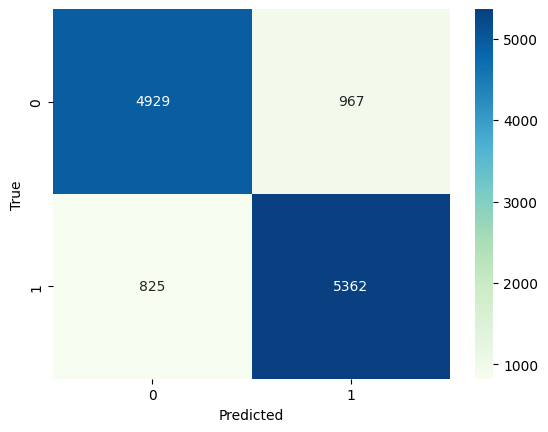

In [216]:
tabla = confusion_matrix(yTest, yPredicted)

sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Metricas

In [217]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(yTest,yPredicted)
recall=recall_score(yTest,yPredicted)
f1=f1_score(yTest,yPredicted,)
precision=precision_score(yTest,yPredicted)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8516924604816685
Recall: 0.8666558913851624
Precision: 0.8472112498024964
f1 score: 0.8568232662192393


# Primer submission a Kaggle

In [218]:
treeModel = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=20,
                                        min_samples_leaf=10)
#Entrenamiento
model = treeModel.fit(X= dsCHP1CopyX, y= dsCHP1CopyY)

In [221]:
yPredictedKaggle = model.predict(dsHotelTestCopyOHE)
#Valores predichos
yPredictedKaggle

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [222]:
dsKaggle = pd.DataFrame(zip(dsHotelTest['id'], yPredictedKaggle), columns=['id', 'is_canceled'])
dsKaggle.to_csv("dsKaggleCorrecto.csv",index=False)

# Segunda submission a Kaggle
Voy a ver como se comporta el modelo al realizar algo similar en 'company' a lo que hice con la variable 'agent'

## Feature Engeneering (segunda submission)

### Para la variable 'company'

In [289]:
dsCHP1CopySS = dsCHP1Copy.copy()  #Realizo una copia del dataframe luego de aplicar las transformaciones (antes de aplicar One Hot Encoding)
dsHotelTestCopySS = dsHotelTestCopy.copy()
dsCHP1CopySS['company'] = dsHotelTrain['company']
dsCHP1CopySS['company'].fillna(-1, inplace=True)
dsHotelTestCopySS['company'].fillna(-1, inplace=True)

In [290]:
dsCHP1CopySS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60414 entries, 0 to 60413
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60414 non-null  object 
 1   lead_time                       60414 non-null  int64  
 2   arrival_date_year               60414 non-null  int64  
 3   arrival_date_month              60414 non-null  int64  
 4   arrival_date_day_of_month       60414 non-null  int64  
 5   stays_in_weekend_nights         60414 non-null  int64  
 6   stays_in_week_nights            60414 non-null  int64  
 7   adults                          60414 non-null  int64  
 8   children                        60414 non-null  int64  
 9   babies                          60414 non-null  int64  
 10  meal                            60414 non-null  object 
 11  country                         60414 non-null  object 
 12  market_segment                  

In [282]:
dsHotelTestCopySS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  int64  
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  Int64  
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

In [291]:
dsCHP1CopySS['company'].value_counts()

company
-1.0      57331
 40.0       386
 223.0      357
 67.0       167
 45.0       112
          ...  
 373.0        1
 243.0        1
 448.0        1
 370.0        1
 217.0        1
Name: count, Length: 274, dtype: int64

In [269]:
dsHotelTestCopySS['company'].value_counts()

company
-1     25218
40       183
223      142
67        64
45        42
       ...  
142        1
112        1
220        1
287        1
380        1
Name: count, Length: 221, dtype: Int64

Dado que 'company' tiene muchos valores unicos tomo el top 10

In [292]:
valores_unicos = dsCHP1CopySS['company'].unique()
diccionario = {}
letra = 'A' 
for valor in valores_unicos:
    diccionario[valor] = letra
    letra = chr(ord(letra) + 1)
dsCHP1CopySS['company'] = dsCHP1CopySS['company'].map(diccionario)
dsHotelTestCopySS['company'] = dsHotelTestCopySS['company'].map(diccionario)
print(diccionario)

{-1.0: 'A', 223.0: 'B', 512.0: 'C', 218.0: 'D', 233.0: 'E', 268.0: 'F', 385.0: 'G', 88.0: 'H', 154.0: 'I', 51.0: 'J', 281.0: 'K', 202.0: 'L', 67.0: 'M', 405.0: 'N', 45.0: 'O', 329.0: 'P', 46.0: 'Q', 197.0: 'R', 137.0: 'S', 366.0: 'T', 174.0: 'U', 40.0: 'V', 144.0: 'W', 227.0: 'X', 86.0: 'Y', 159.0: 'Z', 477.0: '[', 308.0: '\\', 43.0: ']', 219.0: '^', 68.0: '_', 407.0: '`', 81.0: 'a', 465.0: 'b', 343.0: 'c', 466.0: 'd', 353.0: 'e', 424.0: 'f', 485.0: 'g', 38.0: 'h', 94.0: 'i', 153.0: 'j', 72.0: 'k', 20.0: 'l', 47.0: 'm', 286.0: 'n', 195.0: 'o', 358.0: 'p', 277.0: 'q', 355.0: 'r', 12.0: 's', 498.0: 't', 278.0: 'u', 62.0: 'v', 393.0: 'w', 238.0: 'x', 242.0: 'y', 143.0: 'z', 135.0: '{', 331.0: '|', 400.0: '}', 342.0: '~', 110.0: '\x7f', 313.0: '\x80', 78.0: '\x81', 348.0: '\x82', 209.0: '\x83', 452.0: '\x84', 99.0: '\x85', 250.0: '\x86', 118.0: '\x87', 507.0: '\x88', 397.0: '\x89', 321.0: '\x8a', 113.0: '\x8b', 167.0: '\x8c', 9.0: '\x8d', 204.0: '\x8e', 280.0: '\x8f', 83.0: '\x90', 203.0: 

In [293]:
dsCHP1CopySS['company'] = dsCHP1CopySS['company'].where(                #Lo hacemos para el dataframe preprocesado en train
dsCHP1CopySS['company'].isin(dsCHP1CopySS['company'].value_counts().nlargest(10).index), 'Others')

dsHotelTestCopySS['company'] =dsHotelTestCopySS['company'].where(        #Lo hacemos para test
dsHotelTestCopySS['company'].isin(dsHotelTestCopySS['company'].value_counts().nlargest(10).index), 'Others')

In [294]:
dsCHP1CopySS['company'].value_counts()

company
A         57331
Others     1707
V           386
B           357
M           167
O           112
j            99
U            71
K            67
^            65
J            52
Name: count, dtype: int64

In [295]:
dsHotelTestCopySS['company'].value_counts()

company
A         25218
Others      735
V           183
B           142
M            64
O            42
j            41
U            32
N            29
E            25
I            24
Name: count, dtype: int64

Luego de haberle aplicado la misma transformacion a 'company' procedo a aplicarle One Hot Encoding y a entrenar el modelo

### One Hot Encoding

In [314]:
ds_variables_categoricas = dsCHP1CopySS.select_dtypes(include=['object'])
dsCHP1CopySSOHE = pd.get_dummies(dsCHP1CopySS, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsHotelTestCopySSOHE = pd.get_dummies(dsHotelTestCopySS, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsCHP1CopySSOHE['id'] = dsCHP1['id']

In [315]:
dsCHP1CopySSOHE.shape

(60414, 87)

In [316]:
dsHotelTestCopySSOHE.shape

(26535, 86)

In [317]:
categoriasEnComun = (dsCHP1CopySSOHE.columns).intersection(dsHotelTestCopySSOHE.columns)
dsCHP1CopyYSS = dsCHP1CopySSOHE['is_canceled'].copy()
dsHotelTestCopySSOHE= dsHotelTestCopySSOHE[categoriasEnComun]
dsCHP1CopySSOHE = dsCHP1CopySSOHE[categoriasEnComun]
dsCHP1CopySSOHE['is_canceled'] = dsCHP1CopyYSS

##  Entrenamiento y prediccion (SS)

In [318]:
#Creo un dataset con los features que voy a usar para clasificar
dsCHP1CopyXSS = dsCHP1CopySSOHE.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
dsCHP1CopyYSS = dsCHP1CopySSOHE['is_canceled'].copy()

#Genero un conjunto de train a partir del dataframe de train
xTrainSS, xTestSS, yTrainSS, yTestSS = train_test_split(dsCHP1CopyXSS,
                                              dsCHP1CopyYSS,
                                              test_size=0.2,
                                              random_state=243)

## Creacion de clasificador de hiperparametros

In [319]:
treeModel = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=20,
                                        min_samples_leaf=10)
#Entrenamiento
model = treeModel.fit(X= xTrainSS, y= yTrainSS)

In [325]:
yPredictedSS = model.predict(xTestSS)
#Valores predichos
yPredictedSS

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [326]:
#Valores reales
yTestSS.values

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

Text(50.722222222222214, 0.5, 'True')

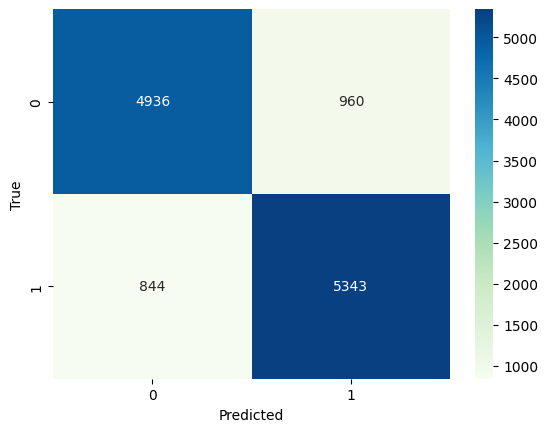

In [327]:
tabla = confusion_matrix(yTestSS, yPredictedSS)

sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [329]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(yTestSS,yPredictedSS)
recall=recall_score(yTestSS,yPredictedSS)
f1=f1_score(yTestSS,yPredictedSS)
precision=precision_score(yTestSS,yPredictedSS)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8506993296366796
Recall: 0.863584936156457
Precision: 0.8476915754402665
f1 score: 0.855564451561249


# Tercera submission a Kaggle

In [349]:
dsCHP1CopyTS = dsCHP1CopyOHE.copy()
dsHotelTestCopyTS = dsHotelTestCopyOHE.copy()

## Eleccion de hiperparametros

In [350]:
dsCHP1CopyXTS = dsCHP1CopyTS.drop(['is_canceled'], axis='columns', inplace=False)
dsCHP1CopyYTS = dsCHP1CopyTS['is_canceled'].copy()

xTrainTS, xTestTS, yTrainTS, yTestTS = train_test_split(dsCHP1CopyXTS,
                                                dsCHP1CopyYTS,
                                                test_size=0.2,    
                                                random_state=243,
                                                stratify=dsCHP1CopyYTS)

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(xTrainTS)))
print('# Datos Prueba: {}'.format(len(xTestTS)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[yTrainTS,yTestTS]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48331
# Datos Prueba: 12083
% Positivos Entrenamiento: 50.553
% Positivos Prueba: 50.550


### KFOLD CV Random Search

In [351]:
def CV_random_search_f1_score_optimizer(nIter, nFolds, maxDepth, minSamplesLeaf):

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,nIter),
               'max_depth':list(range(1,maxDepth)),
               'min_samples_leaf':list(range(1, minSamplesLeaf))}

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=nFolds)

    #Clasificador
    base_tree = tree.DecisionTreeClassifier()

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score)

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=nIter,
                              random_state=200)

    #Busco los hiperparamtros que optimizan F1 Score
    randomcv.fit(xTrainTS,yTrainTS);
    print(randomcv.best_params_)
    print(randomcv.best_score_)
    return randomcv

In [353]:
CV_random_search_f1_score_optimizer(60, 5, 20 ,20)

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8505499444935614


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=60,
                   param_distributions={'ccp_alpha': array([0.        , 0.00084746, 0.00169492, 0.00254237, 0.00338983,
       0.00423729, 0.00508475, 0.0059322 , 0.00677966, 0.00762712,
       0.00847458, 0.00932203, 0.01016949, 0.01101695, 0.01186441,
       0.01271186, 0.01355932, 0.014...
       0.03813559, 0.03898305, 0.03983051, 0.04067797, 0.04152542,
       0.04237288, 0.04322034, 0.0440678 , 0.04491525, 0.04576271,
       0.04661017, 0.04745763, 0.04830508, 0.04915254, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19]},
                   random_state=200, scoring=make_scorer(f1_score))

Generamos iterativamente combinacion de los 4 parametros (numero de iteraciones, nFolds, maxDepth y minSamplesLeaf) para ver como se comporta random search y con que parametros se llega a un score interesante

In [354]:
#for nIter in range(20, 81, 20):
    #for nFolds in range(3, 10, 3):
        #for maxDepth in range(10, 41, 10):
            #for minSamplesLeaf in range(10, 41, 10):
                #print(nIter, nFolds ,maxDepth ,minSamplesLeaf)
                #CV_random_search_f1_score_optimizer(nIter, nFolds ,maxDepth ,minSamplesLeaf)

20 3 10 10
{'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy', 'ccp_alpha': 0.010526315789473684}
0.8022033575996788
20 3 10 20
{'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'gini', 'ccp_alpha': 0.005263157894736842}
0.8008372016204174
20 3 10 30
{'min_samples_leaf': 21, 'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.007894736842105263}
0.7987502455386517
20 3 10 40
{'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'gini', 'ccp_alpha': 0.002631578947368421}
0.799568731791442
20 3 20 10
{'min_samples_leaf': 2, 'max_depth': 12, 'criterion': 'gini', 'ccp_alpha': 0.005263157894736842}
0.8008372016204174
20 3 20 20
{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'gini', 'ccp_alpha': 0.002631578947368421}
0.8032359027525309
20 3 20 30
{'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.815294127210228
20 3 20 40
{'min_samples_leaf': 25, 'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.002631578947368421}
0.8032359027525309


KeyboardInterrupt: 

De toda esta cantidad de muestras podemos ver algunos parametros que tuvieron un score interesante, entre ellos esta por ejemplo:
(40, 3 ,20, 20),
(40, 3 ,30, 20)
(40 ,3 ,30 ,30)
(40, 6 ,20 ,20)

In [356]:
CV_random_search_f1_score_optimizer(160,6,20,20)

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8535742646658093


RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=160,
                   param_distributions={'ccp_alpha': array([0.        , 0.00031447, 0.00062893, 0.0009434 , 0.00125786,
       0.00157233, 0.00188679, 0.00220126, 0.00251572, 0.00283019,
       0.00314465, 0.00345912, 0.00377358, 0.00408805, 0.00440252,
       0.00471698, 0.00503145, 0.00...
       0.04559748, 0.04591195, 0.04622642, 0.04654088, 0.04685535,
       0.04716981, 0.04748428, 0.04779874, 0.04811321, 0.04842767,
       0.04874214, 0.0490566 , 0.04937107, 0.04968553, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19]},
                   random_state=200, scoring=make_scorer(f1_score))

In [ ]:
CV_random_search_f1_score_optimizer(40,9,20,20)

{'min_samples_leaf': 16, 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': 0.001282051282051282}
0.8113223104239551


RandomizedSearchCV(cv=StratifiedKFold(n_splits=9, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=40,
                   param_distributions={'ccp_alpha': array([0.        , 0.00128205, 0.0025641 , 0.00384615, 0.00512821,
       0.00641026, 0.00769231, 0.00897436, 0.01025641, 0.01153846,
       0.01282051, 0.01410256, 0.01538462, 0.01666667, 0.01794872,
       0.01923077, 0.02051282, 0.021...
       0.03205128, 0.03333333, 0.03461538, 0.03589744, 0.03717949,
       0.03846154, 0.03974359, 0.04102564, 0.04230769, 0.04358974,
       0.04487179, 0.04615385, 0.0474359 , 0.04871795, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19]},
                   random_state=200, scoring=make_scorer(f1_score))

## Prediccion y Evaluacion del modelo con mejores hiperparametros

In [ ]:
bestParams = CV_random_search_f1_score_optimizer(40,9,20,20).best_params_
arbol=tree.DecisionTreeClassifier().set_params(**bestParams)
arbol.fit(xTrain, yTrain)

{'min_samples_leaf': 16, 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': 0.001282051282051282}
0.8114448079196098


DecisionTreeClassifier(ccp_alpha=0.001282051282051282, criterion='entropy',
                       max_depth=19, min_samples_leaf=16)

F1-Score: 0.801886236368995


Text(50.722222222222214, 0.5, 'True')

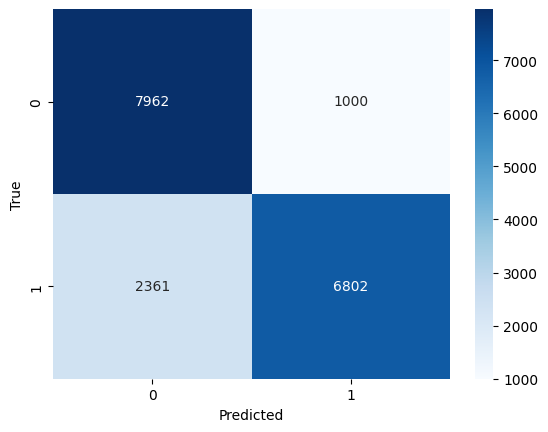

In [ ]:
#Hago predicción sobre el set de evaluacion
yPred= arbol.predict(xTest)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(yTest, yPred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(yTest,yPred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Prediccion con hotels_test.csv

In [ ]:
treeModel = tree.DecisionTreeClassifier(**CV_random_search_f1_score_optimizer(40,9,20,20).best_params_)
#Entrenamiento
model = treeModel.fit(X= dsCHP1CopyX, y= dsCHP1CopyY)
yPredictedKaggle = model.predict(dsHotelTestCopy)
#Valores predichos
yPredictedKaggle

{'min_samples_leaf': 16, 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': 0.001282051282051282}
0.8114448079196098


array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [ ]:
dsKaggle = pd.DataFrame(zip(dsHotelTest['id'], yPredictedKaggle), columns=['id', 'is_canceled'])
dsKaggle.to_csv("dsKaggleConHiperparametros.csv",index=False)